Import delle librerie

In [98]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import combinations
import random
import osmnx as ox

Definizione della funzione per la creazione della stringa nella formattazione corretta per la lettura da parte di Minizinc

In [151]:
def dataStringGenerator(df, nome_variabile):
    stringa = nome_variabile +" = [";
    ## sezione per la matrice delle distanze
    if df.shape[0] == df.shape[1]:
        for i in range(df.shape[0]):
            if i == 0:
                stringa = stringa + "| "
            else:
                stringa = stringa + "         | "
            for j in range(df.shape[1]):
                stringa = stringa + str(df.iat[i, j]) 
                if j != len(df)-1:
                    stringa = stringa + ", "
                else:
                    stringa = stringa +  os.linesep # aggiunta di \n a fine della riga 

        stringa = stringa + "         |];"
    # sezione per i semplici array di numeri
    else:
        for i in range(df.shape[0]):
            if i != df.shape[0]-1:
                stringa = stringa + str(df.iat[i,0]) + ", "
            else:
                stringa = stringa + str(df.iat[i,0])
        
        stringa = stringa + "];"
    
    return stringa

Definizione della funzione che permette la generazione di ordini casuali


In [152]:
def ordersGeneretor(orari_possibili, n_pizze_max, n_nodi, n_ordini):
    orari = np.random.choice(orari_possibili, size=n_ordini)
    #num_pizze = np.random.randint(1, n_pizze_max+1, size=n_ordini)
    xx = np.random.gamma(2,2, size=n_ordini)
    num_pizze = np.zeros(n_ordini, dtype=int)
    for i in range(n_ordini):
        num_pizze[i] = int(np.ceil(xx[i]))
        if num_pizze[i] > 16:
            num_pizze[i] = 16
            
    dest = np.random.randint(2, n_nodi+1, size=n_ordini)
    
    return orari, num_pizze, dest

##### Apertura e lettura del file

In [101]:
# Apertura e lettura del file
#file = open("data.txt","r")
#data = file.read()

df = pd.read_table('data.txt', sep=',', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,6,5,3,2,2,7,4,10,3,9,3,8,2,8,12
1,4,7,6,5,12,4,3,7,13,11,11,10,10,9,9,8,13,13
2,3,2,1,6,4,9,2,5,7,6,4,1,2,3,2,6,3,3


##### Divisione dei dati letti in input e creazione delle liste contenenti i nodi e i pesi relativi

La prima riga rappresenta il nodo di partenza di ogni arco, la seconda il node di arrivo e la terza il peso di ogni arco

In [102]:
# Divisione del file nelle tre righe di dati
#lista = data.split("\n")
# parsing in lista di interi
#da = [int(i) for i in lista[0].split(', ')]
#a = [int(i) for i in lista[1].split(', ')]
#pesi = [int(i) for i in lista[2].split(', ')]
da = df[0:1]
a = df[1:2]
pesi = df[2:3]


##### Generazione del grafo

In [103]:
#g = nx.Graph()
#for i in range(len(da)):
#     g.add_edge(da[i],a[i], weight=pesi[i])
#nx.draw_planar(g, with_labels = True)
#plt.savefig("prova.png")

In [104]:
# Creation of the graph
G = nx.Graph()

# Extract the nodes from the lists of edges and sort them
nodes = pd.unique(pd.concat([df.loc[0],df.loc[1]]))
nodes.sort()

for i in nodes:
    G.add_node(i)
    
for i in range(da.size):
    G.add_edge(df.iat[0,i], df.iat[1,i], weight=df.iat[2,i])

{(1, 4): Text(0.34670138800302375, -0.054194368314360586, '3'),
 (1, 7): Text(-0.05846804085747434, -0.1254196865359969, '2'),
 (1, 6): Text(-0.028990084285796136, -0.6221615117591379, '1'),
 (2, 3): Text(0.0942691875952753, 0.39450037715754116, '2'),
 (2, 7): Text(-0.2289841196894325, 0.2053443159564648, '5'),
 (2, 8): Text(-0.24628324946887983, 0.35590593557605077, '6'),
 (3, 4): Text(0.44081959657308756, 0.2783272511175583, '9'),
 (3, 10): Text(0.5304232587526785, 0.5417112065146273, '1'),
 (3, 9): Text(0.2764465389314259, 0.5384063259311598, '3'),
 (4, 11): Text(0.6673289439663929, 0.26026457128950176, '6'),
 (5, 6): Text(-0.379699015631476, -0.9877688893757182, '6'),
 (5, 12): Text(-0.6072910897815781, -0.8210446557100641, '4'),
 (7, 13): Text(-0.4121825806155947, -0.05495287479363895, '7'),
 (8, 9): Text(-0.06410589813272924, 0.4998118843496693, '2'),
 (8, 13): Text(-0.429481710395042, 0.09560874482594699, '3'),
 (9, 10): Text(0.4479663226868072, 0.6838595383487887, '2'),
 (10, 1

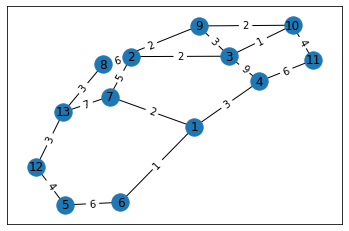

In [105]:
#nx.draw_planar(G, with_labels=True)
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

Generazione della matrice delle distanze

In [106]:
dictDist= dict(nx.all_pairs_dijkstra_path_length(G))

In [107]:
mDist = pd.DataFrame(dictDist)
mDistSorted = mDist.sort_index()

Creazione della stringa che sarà il file di input per il programma Minizinc e stampa su file

In [108]:
stringa = dataStringGenerator(mDistSorted, "mdist")

In [109]:
#file = open('myfile.dzn', 'w')
#file.write(stringa)
#file.close()

## Integrazione di OpenStreetMaps

Recupero di un grafo di una città e manipolazione per rendere utilizzabili le distanze

/home/alessio/anaconda3/envs/ox/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


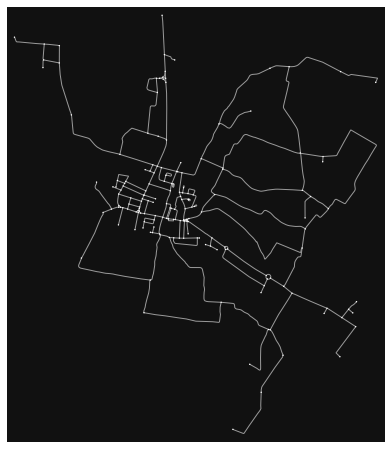

In [153]:
place_name = "Casaloldo, Mantova, Italy"

# dowload del grafico
graph = ox.graph_from_place(place_name, network_type="drive")
# conversione delle etichette con numeri consecutivi partendo da 1
gg = nx.convert_node_labels_to_integers(graph)
# conversione ad un grafo indiretto
dGraph = gg.to_undirected()

#type(dGraph)
fig, ax = ox.plot_graph(dGraph, node_size=2)
#edge_centrality = nx.closeness_centrality(nx.line_graph(dGraph))
#nx.set_edge_attributes(dGraph, edge_centrality, "edge_centrality")
#ec = ox.plot.get_edge_colors_by_attr(dGraph, "length", cmap="inferno")
#fig, ax = ox.plot_graph(dGraph, edge_color=ec, edge_linewidth=0.8, node_size=1)
#type(graph)
#nx.classes.multidigraph.MultiDiGraph
#xx = nx.spring_layout(graph,k=1, dim=2, scale=2)
#plot = nx.draw_networkx(graph)

In [154]:
# calcolo della minore distanza tra tutte le coppie di nodi
# --> la matrice sarà simmetrica perchè il grafo è indiretto
labels2 = nx.get_edge_attributes(dGraph, 'length')
dictDist2 = dict(nx.all_pairs_dijkstra_path_length(dGraph))
mDist2 = pd.DataFrame(dictDist2)
mDistSorted2 = mDist2.sort_index()
#mDistSorted3 = mDistSorted2.reset_index()
#mDistSorted4 = mDistSorted3.T.reset_index()
mDistSorted2.head()

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,0,2,5,8,13,4,6,11,17,13,...,15,15,14,17,11,14,13,13,12,13
1,2,0,4,7,12,3,5,10,16,12,...,14,14,13,16,11,13,12,12,11,12
2,5,4,0,3,11,7,9,10,15,11,...,13,13,12,15,12,15,16,16,15,16
3,8,7,3,0,8,6,6,7,12,8,...,10,10,9,12,12,12,13,13,12,13
4,13,12,11,8,0,9,9,8,8,4,...,6,6,5,8,15,12,13,13,12,14


In [214]:
##### xx=nx.spring_layout(graph)
#nx.draw_networkx(graph,xx)

#RandG = nx.gnm_random_graph(10,18,seed=1234)
#posG=nx.spring_layout(RandG)
#nx.draw_networkx(RandG,posG)

#for i in RandG.edges:
#    G.add_edges_from(i, weight=np.random())
#np.random.randint(low=1,high=15)


def ER(n, p):
    V = set([v for v in range(n)])
    
    g = nx.Graph()
    g.add_nodes_from(V)
    
    for combination in combinations(V, 2):
        a = random()
        if a < p:
            g.add_edge(combination[0], combination[1])
        
        flag = nx.check_planarity(g)
        if  flag[0] == False:
            g.remove_edge(combination[0], combination[1])
    
    return g

#G = ER(15,0.6)
#xx=nx.planar_layout(G)
#nx.draw_networkx(G,xx)
#
#graph = nx.fast_gnp_random_graph(10,2)
#xx=nx.spring_layout(graph)
#nx.draw_networkx(graph,xx)


## Generazione dei file di dati da dare in input a minizinc

In [155]:
orari_possibili = ["19.00", "19.15", "19.30", "19.45", "20.00", "20.15", "20.30", "20.45", "21.00", "21.15", "21.30"]
# np.random.randint(1,17) --> generatore di numeri tra [1,16] aka generatore di numero di pizze
# np.random.randint(2,len(mDistSorted2)+1) aka generatore di destinazioni
#orario
#num_pizze
#dest

N = 2
orari, pizze, nodi = ordersGeneretor(orari_possibili, 16, mDistSorted2.shape[0], N)
dfOrari = pd.DataFrame(orari)
dfPizze = pd.DataFrame(pizze)
dfNodi = pd.DataFrame(nodi)


stringa = dataStringGenerator(pd.DataFrame(mDistSorted2/18,dtype=int), "mdist")
stringaOrari = dataStringGenerator(dfOrari, "orario")
stringaPizze = dataStringGenerator(dfPizze, "num_pizze")
stringaNodi = dataStringGenerator(dfNodi, "dest")

file = open('data.dzn', 'w')
file.write(stringa + os.linesep 
           + stringaOrari + os.linesep 
           + stringaPizze + os.linesep 
           + stringaNodi+ os.linesep
           + "N = " + str(N) + ";" + os.linesep
           + "k = " + str(mDistSorted2.shape[0]) + ";" + os.linesep)
file.close()